# Gate Cutting to Reduce Circuit Depth

In this tutorial, we will simulate some expectation values on a circuit of a certain depth by cutting gates resulting in swap gates and executing subexperiments on shallower circuits.

Like any circuit knitting technique, gate cutting can be described as three consecutive steps:

- **decompose** some non-local gates in the circuit and possibly separate the circuit into subcircuits
- **execute** many sampled subexperiments on the backend(s)
- **reconstruct** the expectation value of the full-sized circuit

In [1]:
import numpy as np
from qiskit import transpile
from qiskit.circuit.library import EfficientSU2
from qiskit.providers.fake_provider import FakeHanoiV2 as FakeHanoi
from qiskit.quantum_info import PauliList

### Create a circuit to run on the backend

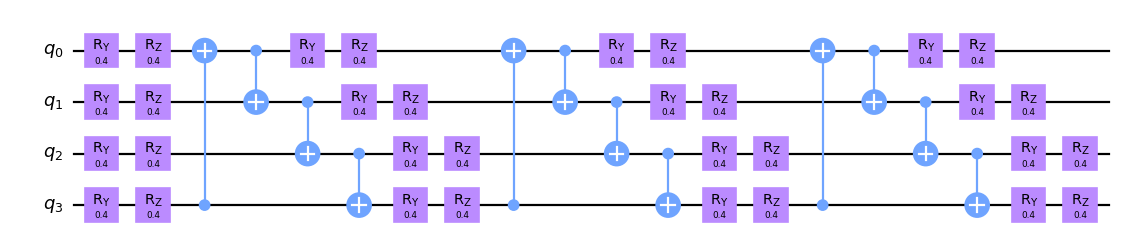

In [2]:
circuit = EfficientSU2(num_qubits=4, entanglement="circular").decompose()
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)
circuit.draw("mpl", scale=0.8)

### Specify some observables

Currently, only `Pauli` observables with phase equal to 1 are supported. Full support for `SparsePauliOp` is expected in CKT v0.4.0.

In [3]:
observables = PauliList(["ZZII", "IZZI", "IIZZ", "XIXI", "ZIZZ", "IXIX"])

### Transpile the circuit, visualize the swaps, and note the depth

We choose a layout that requires two swaps to execute the gates between qubits 3 and 0 and another two swaps to return the qubits to their initial positions.

In [4]:
backend = FakeHanoi()

transpiled_qc = transpile(circuit, backend=backend, initial_layout=[0, 1, 2, 3])
print(f"Transpiled circuit depth: {transpiled_qc.depth()}")

Transpiled circuit depth: 59


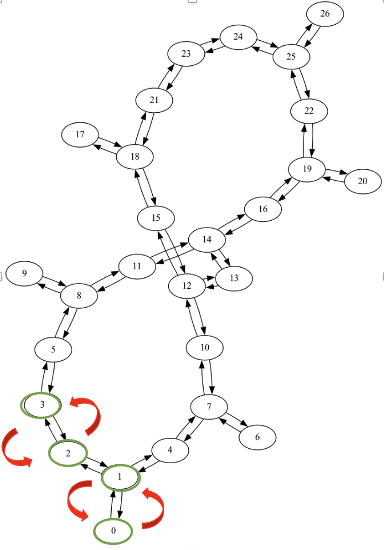

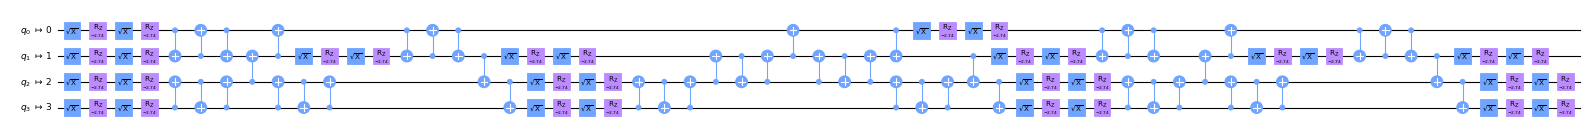

In [5]:
transpiled_qc.draw("mpl", scale=0.4, idle_wires=False, fold=-1)

### Replace distant gates with `TwoQubitQPDGate`s by specifying their indices, and generate the cutting experiments using `generate_cutting_experiments`.

`cut_gates` will replace the gates in the specified indices with `TwoQubitQPDGate`s and also return a list of `QPDBasis` instances -- one for each gate decomposition.

`generate_cutting_experiments` will create the subexperiments needed to run on the backend in order to reconstruct an estimation of the uncut expectation value. It also returns the weights associated with each subexperiment.

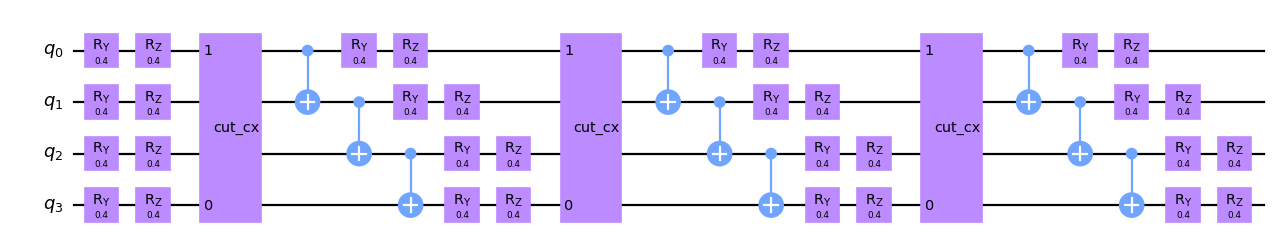

In [6]:
from circuit_knitting.cutting import cut_gates, generate_cutting_experiments

# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit, cut_indices)
subexperiments, weights = generate_cutting_experiments(qpd_circuit, observables, np.inf)
qpd_circuit.draw("mpl", scale=0.8)

### Calculate the sampling overhead for the chosen cuts

The sampling overhead is the factor by which the number of samples must increase for the quasiprobability decomposition to result in the same amount of error, $\epsilon$, as one would get by sampling the original circuit. Cutting CNOT and CZ gates incurs a sampling overhead of $O(9^k/\epsilon^2)$, where $k$ is the number of cuts [[Mitarai, Fujii]](https://arxiv.org/abs/1909.07534); however, other gates may have higher or lower exponential bases. For example, the sampling overhead resulting from cutting SWAP gates scales with complexity $O(49^k/\epsilon^2)$ [[Mitarai, Fujii]](https://arxiv.org/abs/2006.11174).

Here we cut three CNOT gates, resulting in a sampling overhead of $9^3$.

In [7]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 729.0


### Demonstrate that the QPD subexperiments will be shallower after cutting distant gates

Here is an example of an arbitrarily chosen subexperiment generated from the QPD circuit. Its depth has been reduced by more than half. Many of these probabilistic subexperiments must be generated and evaluated in order to reconstruct an expectation value of the deeper circuit.

Original circuit depth after transpile: 59
QPD subexperiment depth after transpile: 28


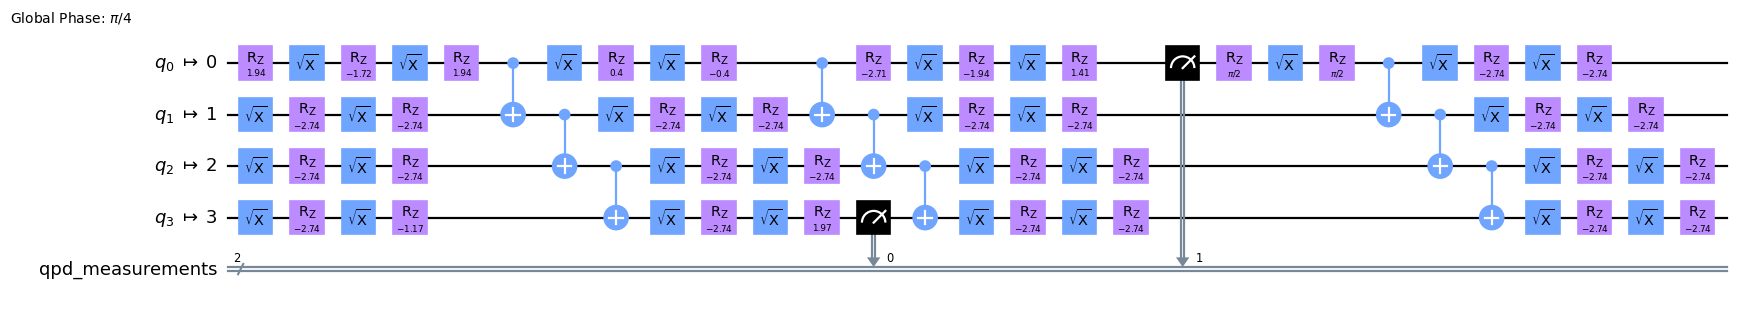

In [8]:
from circuit_knitting.cutting.qpd import decompose_qpd_instructions

# Set some arbitrary bases to which each of the 3 QPD gates should decompose
arbitrary_basis_ids = [1, 3, 4]
for idx, basis_id in zip(cut_indices, arbitrary_basis_ids):
    qpd_circuit[idx].operation.basis_id = basis_id

# Decompose QPDGates in a circuit into Qiskit operations and measurements
qpd_circuit_dx = decompose_qpd_instructions(qpd_circuit, [[idx] for idx in cut_indices])

# Transpile the decomposed circuit to the same layout
transpiled_qpd_circuit = transpile(
    qpd_circuit_dx, backend=backend, initial_layout=[0, 1, 2, 3]
)

print(f"Original circuit depth after transpile: {transpiled_qc.depth()}")
print(f"QPD subexperiment depth after transpile: {transpiled_qpd_circuit.depth()}")
transpiled_qpd_circuit.draw("mpl", scale=0.8, idle_wires=False, fold=-1)

In [9]:
from qiskit_aer.primitives import Sampler

# Set up Qiskit Aer Sampler primitive.
sampler = Sampler(run_options={"shots": 2**12})

# Retrieve results from each subexperiment
results = sampler.run(subexperiments).result()

In [10]:
from circuit_knitting.cutting import reconstruct_expectation_values

# Include the number of bits used for cutting measurements in the results
for i in range(len(subexperiments)):
    results.metadata[i]["num_qpd_bits"] = len(
        subexperiments[i].cregs[0]
    )

reconstructed_expvals = reconstruct_expectation_values(
    observables,
    weights,
    results,
)

### Compare reconstructed expectation values to exact expectation values from the original circuit

In [11]:
from qiskit_aer.primitives import Estimator


estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([circuit] * len(observables), list(observables)).result().values
)
print(
    f"Reconstructed expectation values: {[np.round(reconstructed_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Exact expectation values: {[np.round(exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Errors in estimation: {[np.round(reconstructed_expvals[i]-exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Relative errors in estimation: {[np.round((reconstructed_expvals[i]-exact_expvals[i]) / exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)

Reconstructed expectation values: [0.49584961, 0.56402588, 0.39923096, -0.22259521, 0.20874023, -0.28356934]
Exact expectation values: [0.50983039, 0.56127511, 0.36167086, -0.23006544, 0.23416169, -0.20855487]
Errors in estimation: [-0.01398078, 0.00275077, 0.0375601, 0.00747022, -0.02542146, -0.07501446]
Relative errors in estimation: [-0.02742242, 0.00490092, 0.1038516, -0.03246999, -0.1085637, 0.35968694]


In [12]:
import qiskit.tools.jupyter  # noqa: F401

%qiskit_version_table